In [22]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import squidpy as sq
import numpy as np

from PIL import Image
import networkx as nx
import matplotlib.cm as cmx
import matplotlib.colors as colors

import ncem

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 0
sc.settings.figdir = figdir


# remove later
base_path = '/Users/anna.schaar/phd/'
datadir = base_path + "datasets/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Scanpy 1.7.2, on 2021-06-22 15:02.


# MERFISH - brain

In [416]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='zhang',
    data_path=datadir + 'zhang/',
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata


  5%|▍         | 3/64 [00:00<00:03, 16.47it/s]

adding graph-level covariates


100%|██████████| 64/64 [00:04<00:00, 15.62it/s]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


In [436]:
from patsy import dmatrix

In [461]:
target = np.random.randint(2, size=(6, 3))

In [462]:
target

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 1, 1],
       [1, 0, 0],
       [1, 1, 1]])

In [463]:
source = np.random.randint(2, size=(6, 3))

In [464]:
source

array([[0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0]])

In [465]:
data = {"target": target, "source": source}

In [466]:
dmatrix("target:source-1", data)

DesignMatrix with shape (6, 9)
  Columns:
    ['target[0]:source[0]',
     'target[1]:source[0]',
     'target[2]:source[0]',
     'target[0]:source[1]',
     'target[1]:source[1]',
     'target[2]:source[1]',
     'target[0]:source[2]',
     'target[1]:source[2]',
     'target[2]:source[2]']
  Terms:
    'target:source' (columns 0:9)
  (to view full data, use np.asarray(this_obj))

In [467]:
interactions = np.array(dmatrix("target:source-1", data))

In [468]:
interactions

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0.]])

In [470]:
np.sum(np.concatenate(
    np.expand_dims(
        np.split(interactions, indices_or_sections=3, axis=1),
        axis=-1),
    axis=-1
), axis=0)

array([[1., 2., 2.],
       [1., 1., 0.],
       [2., 1., 1.]])

In [130]:
import pandas as pd
interaction_matrix = []
for k, adata in interpreter.data.img_celldata.items():
    im = sq.gr.interaction_matrix(
        adata,
        cluster_key='subclass_preprocessed',
        connectivity_key='adjacency_matrix',
        normalized=True,
        copy=True
    )
    im = pd.DataFrame(im, columns=list(np.unique(adata.obs['subclass_preprocessed'])), index=list(np.unique(adata.obs['subclass_preprocessed'])))
    interaction_matrix.append(im)
df_concat = pd.concat(interaction_matrix)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean().sort_index(axis=1)
interpreter.data.celldata.uns['subclass_preprocessed_interactions'] = np.array(df_means)

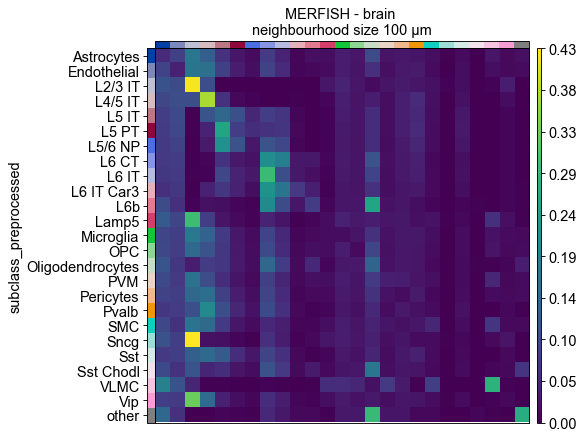

In [134]:
sc.set_figure_params(scanpy=True, fontsize=13)
sq.pl.interaction_matrix(
    interpreter.data.celldata,
    cluster_key='subclass_preprocessed',
    connectivity_key='adjacency_matrix',
    figsize=(5,5),
    title='MERFISH - brain \nneighbourhood size 100 μm'
)

In [ ]:
sq.gr.nhood_enrichment(
    interpreter.data.celldata,
    cluster_key='subclass_clean',
    connectivity_key='adjacency_matrix'
)

In [ ]:
sq.pl.nhood_enrichment(
    interpreter.data.celldata,
    cluster_key='subclass_clean',
    connectivity_key='adjacency_matrix'
)

### Figure 1: Modeling cell communication as spatial cell state dependencies.
#### UMAP mouse 1 slice 153 - Fig. 1b

n cells:  7439


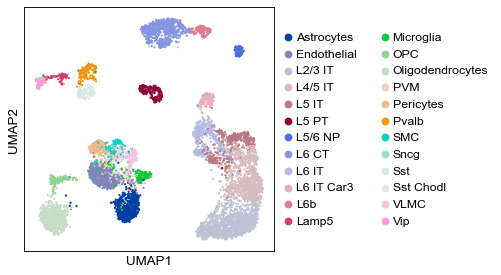

In [46]:
interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


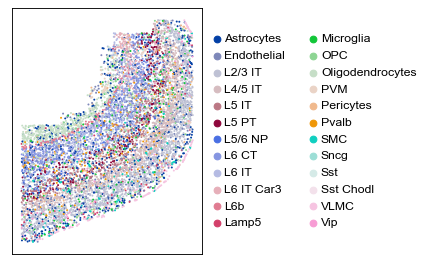

In [31]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True,
    copy=True
)

#### Example image 488 of mouse 1 slice 153 (dataset 1 sample 3) - Fig. 1b

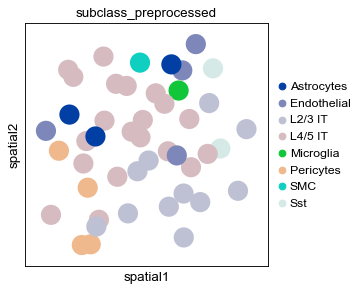

In [33]:
dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]
# for hte MERFISH brain datase, coordinates are given as µm, which is transformed to pixels to match the image
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']
sc.pl.spatial(
    dataset1_sample3_486, 
    spot_size=200, 
    color='subclass_preprocessed', 
)

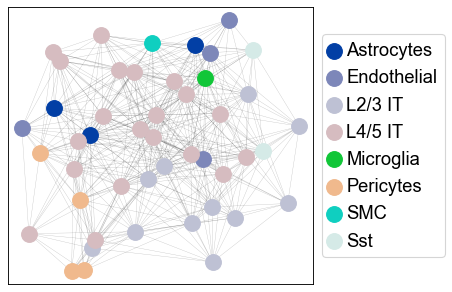

In [35]:
panel_width = 6.
panel_height = 4.
edge_width = 0.3

sc.set_figure_params(scanpy=True, fontsize=18)
plt.rcParams["axes.grid"] = False

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass_preprocessed"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=(panel_width, panel_height))
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=200,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_preprocessed_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.set_position([box.x0, box.y0, box.width, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
# plt.savefig("dataset1_sample3_488_graph_10um.pdf")

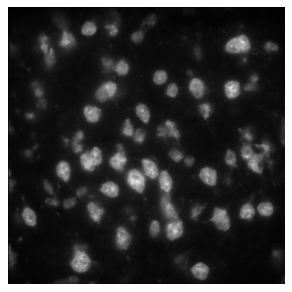

In [90]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

# readoutName polyT are in frames [154:160] with zPos (µm) [0.  1.5 3.  4.5 6.  7.5 9. ]
# we show the center z-plane at z=4.5µm
img = sq.im.ImageContainer(images[:, :, 157])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

### Figure 2: Attributing cell heterogeneity to niche composition.
#### UMAP of L2/3 IT sub-states in slice 153 - Fig. 2 a

n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


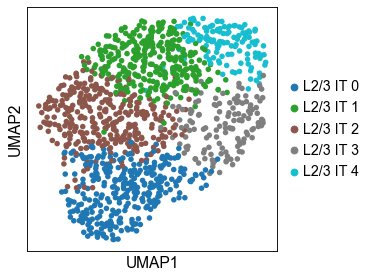

In [417]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=14,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

Trying to set attribute `.uns` of view, copying.


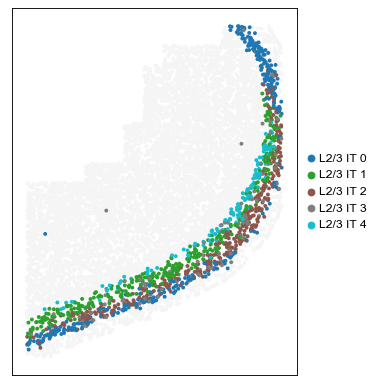

In [418]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True
)

#### UMAPs of L2/3 IT neighbourhoods in slice 153 - Fig. 1c

In [419]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

100%|██████████| 153/153 [01:54<00:00,  1.34it/s]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


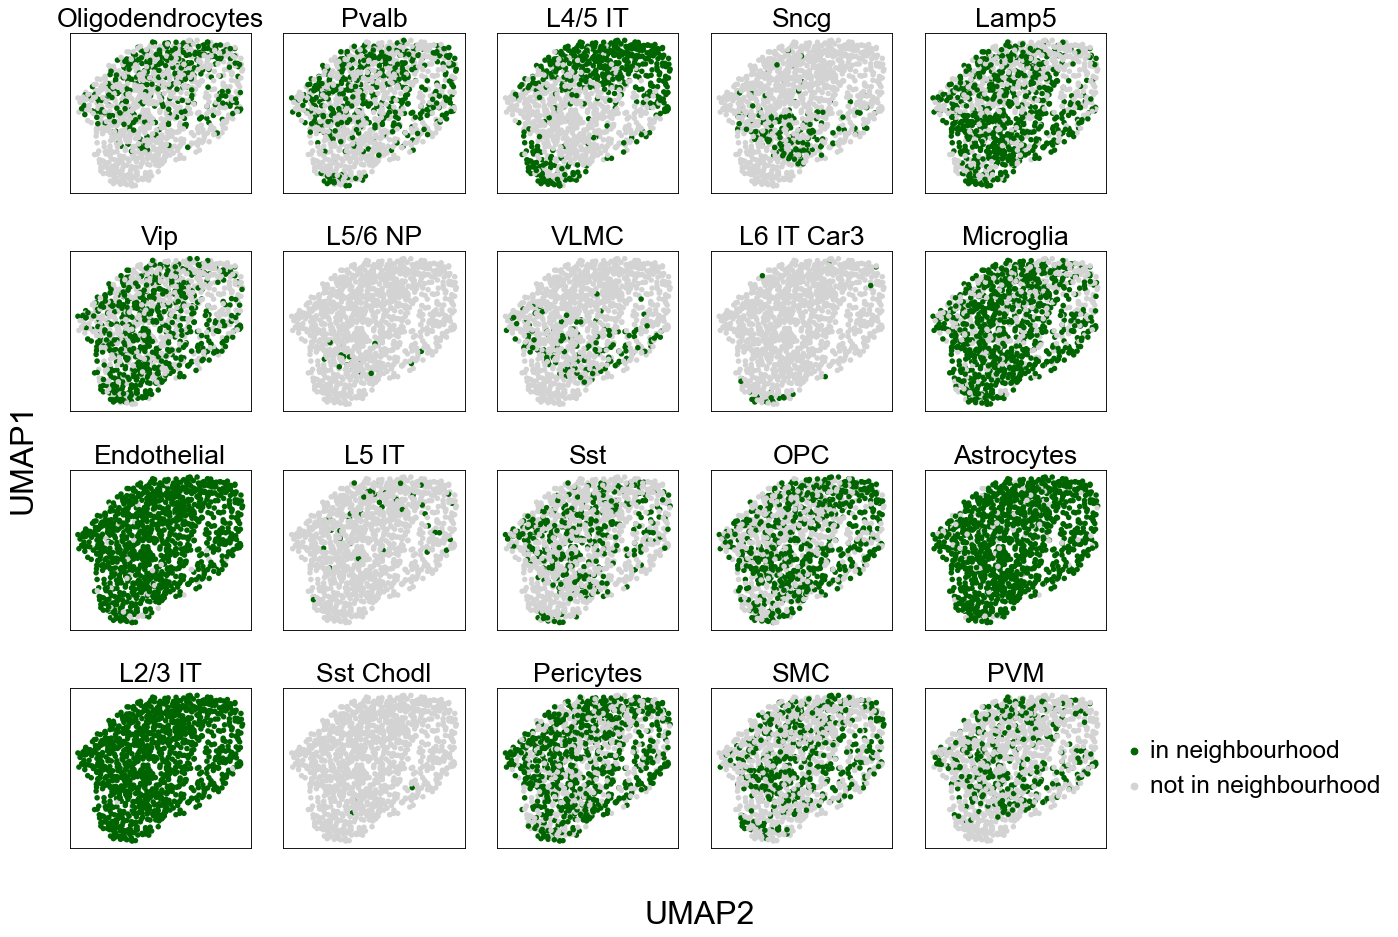

In [39]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

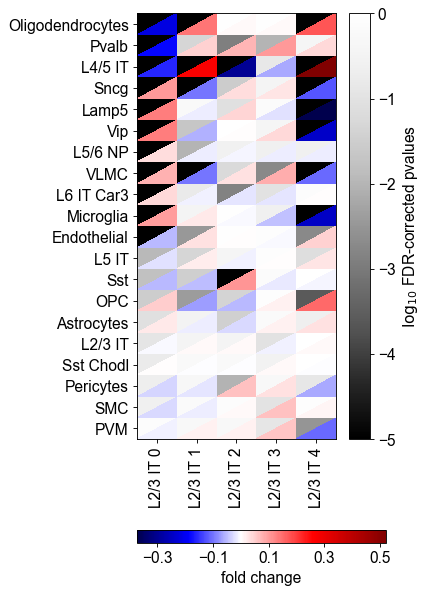

In [427]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

### Variance decomposition - Supp. Fig. 4a

In [42]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')

100%|██████████| 64/64 [04:38<00:00,  4.35s/it]


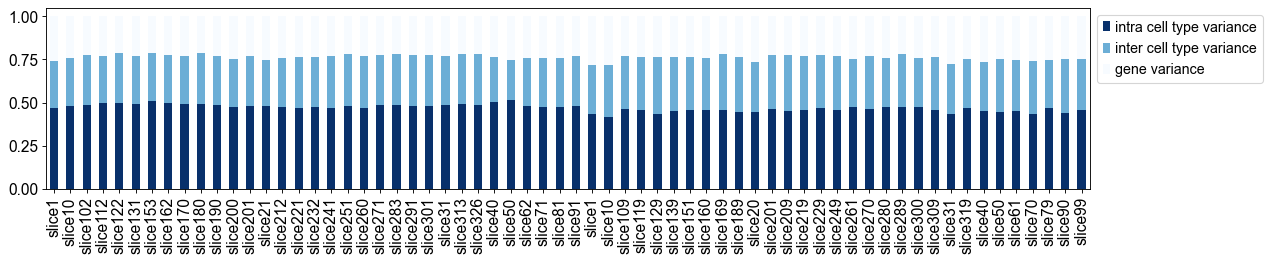

In [43]:
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

### Ligand-receptor analysis - Supp. Fig. 7a-b

n cells: 27638


  0%|          | 0/1000 [00:00<?, ?permutation/s]

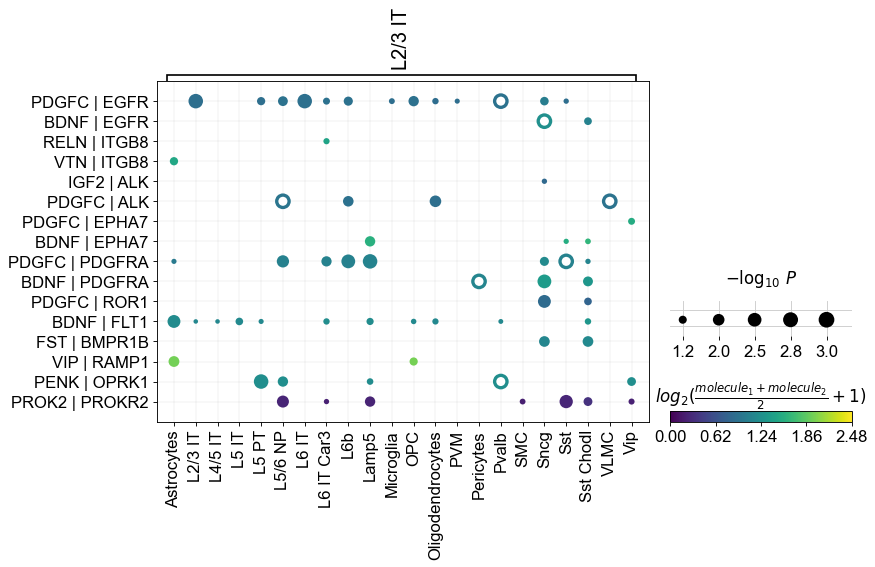

In [47]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L2/3 IT',
    undefined_type='other',
)

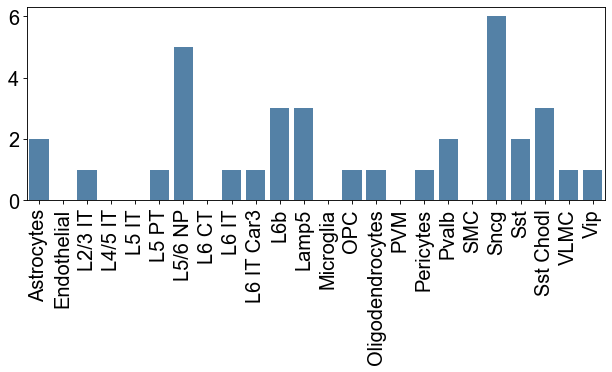

In [48]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

n cells: 7439


  0%|          | 0/1000 [00:00<?, ?permutation/s]

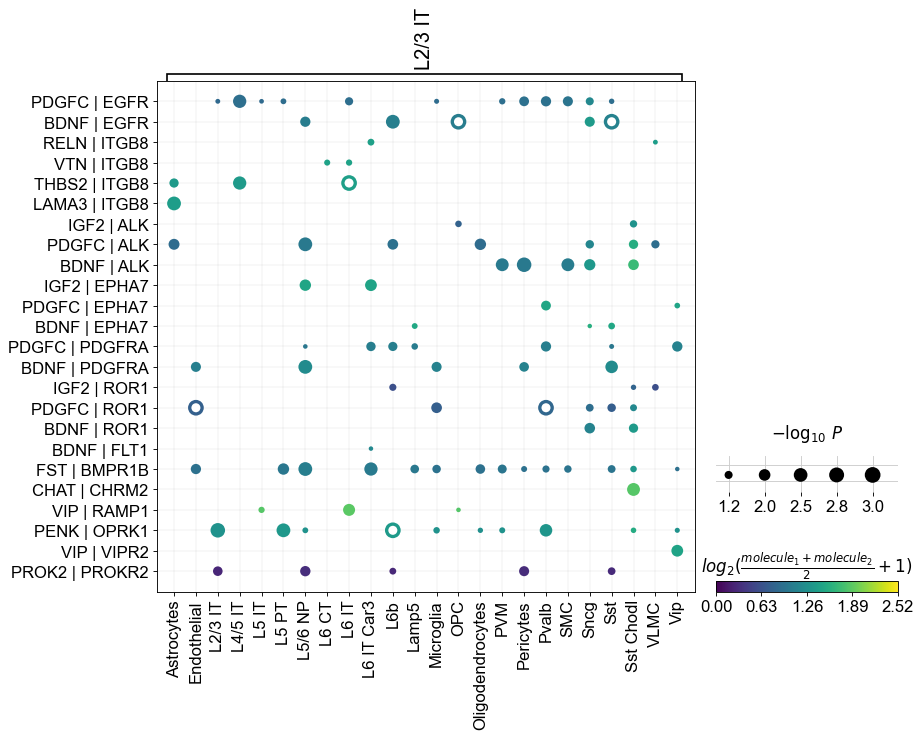

In [49]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L2/3 IT',
    undefined_type='other',
)

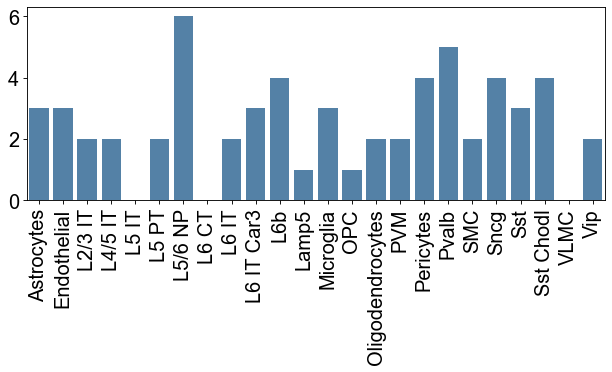

In [50]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

### Noise structure - Supp. Fig. 12a

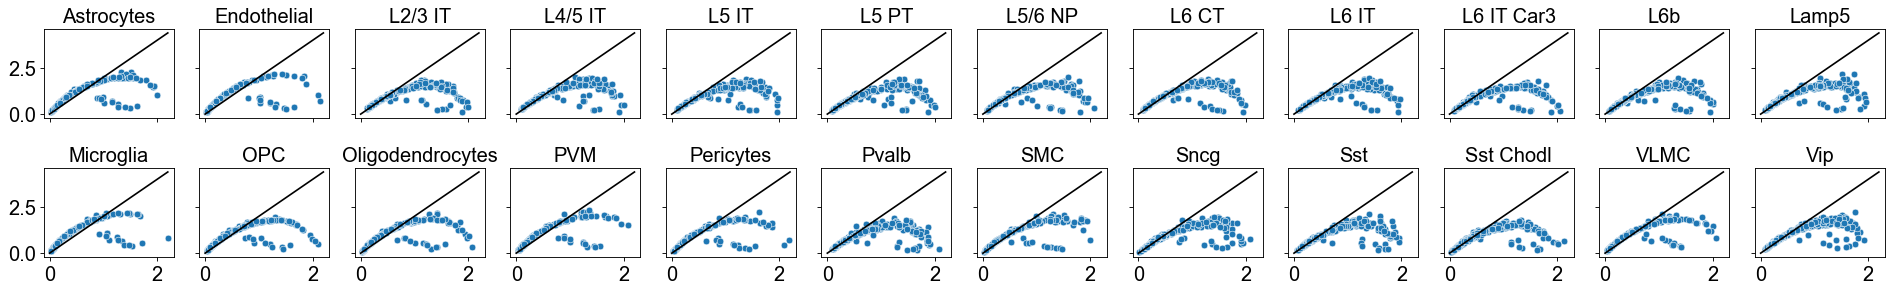

In [55]:
interpreter.data.noise_structure(undefined_type='other', min_x=0.0, max_x=2.2)

##  Replicate analysis for attribution of molecular states to neighborhoods in the MERFISH – brain data set. - Supp. Fig 5b-f

n cells:  6759


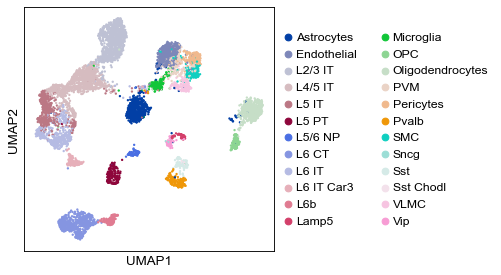

In [56]:
interpreter.data.umap(
    image_key= "mouse1_slice162",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

Trying to set attribute `.uns` of view, copying.


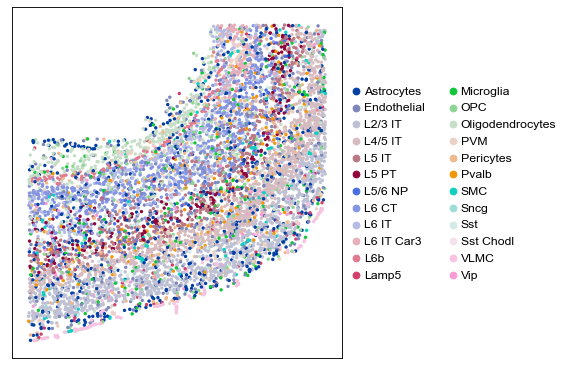

In [57]:
interpreter.data.spatial(
    image_key= "mouse1_slice162",
    undefined_type='other',
    fontsize=12,
    copy=False
)

n cells:  946
L2/3 IT0    226
L2/3 IT1    209
L2/3 IT2    193
L2/3 IT3    191
L2/3 IT4    127
Name: L2/3 IT_substates, dtype: int64


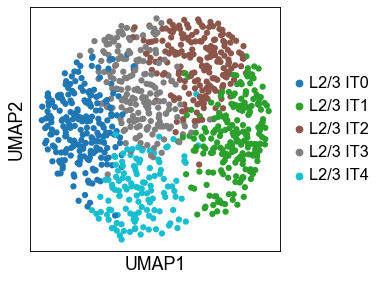

In [60]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

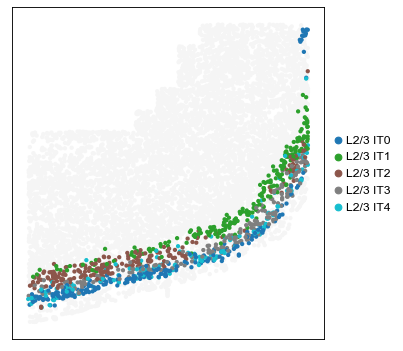

In [61]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
)

In [428]:
filter_titles = ['L4/5 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L2/3 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice162',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

100%|██████████| 153/153 [01:49<00:00,  1.40it/s]


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT_substates, dtype: int64


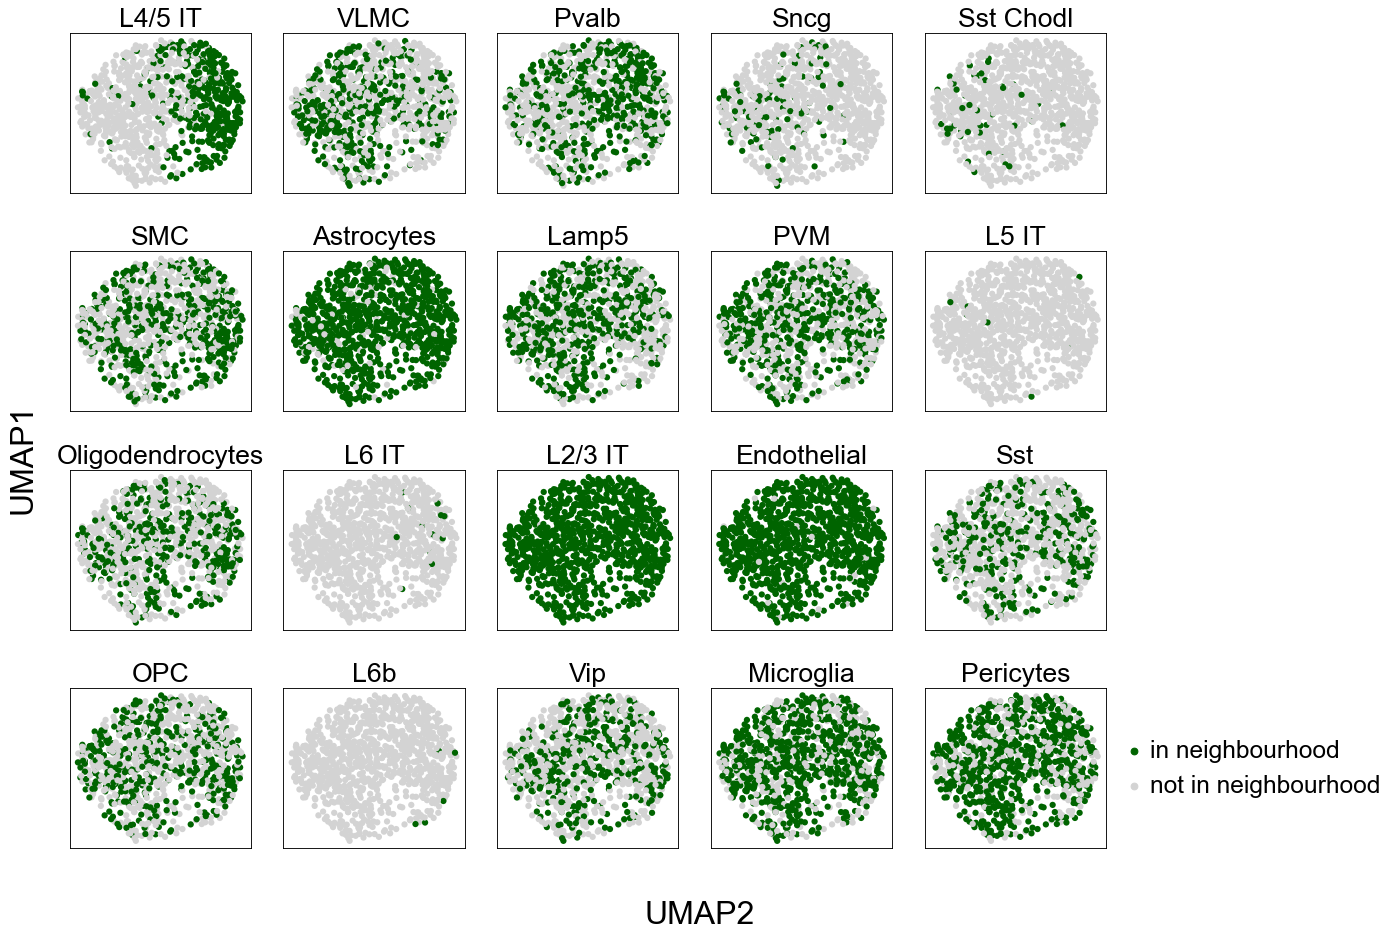

In [63]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

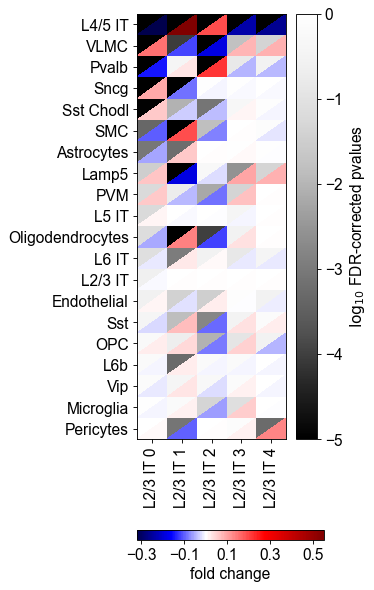

In [430]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    panel_width=3,
    linspace=(-0.3, 0.5, 5)
)

In [431]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='zhang',
    data_path=datadir + 'zhang/',
    radius=6000,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata


  0%|          | 0/64 [00:00<?, ?it/s]

adding graph-level covariates


100%|██████████| 64/64 [03:21<00:00,  3.15s/it]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 4379.109375

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


In [432]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='mouse1_slice153',
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

100%|██████████| 153/153 [02:44<00:00,  1.07s/it]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


In [434]:
fold_change

L2/3 IT_substates  L2/3 IT 0  L2/3 IT 1  L2/3 IT 2  L2/3 IT 3  L2/3 IT 4
new_index                                                               
Oligodendrocytes         0.0        0.0        0.0        0.0        0.0
Pvalb                    0.0        0.0        0.0        0.0        0.0
L4/5 IT                  0.0        0.0        0.0        0.0        0.0
Sncg                     0.0        0.0        0.0        0.0        0.0
Lamp5                    0.0        0.0        0.0        0.0        0.0
Vip                      0.0        0.0        0.0        0.0        0.0
L5/6 NP                  0.0        0.0        0.0        0.0        0.0
VLMC                     0.0        0.0        0.0        0.0        0.0
L6 IT Car3               0.0        0.0        0.0        0.0        0.0
Microglia                0.0        0.0        0.0        0.0        0.0
Endothelial              0.0        0.0        0.0        0.0        0.0
L5 IT                    0.0        0.0        0.0        0.0        0.0
Sst                      0.0        0.0        0.0        0.0        0.0
OPC                      0.0        0.0        0.0        0.0        0.0
Astrocytes               0.0        0.0        0.0        0.0        0.0
L2/3 IT                  0.0        0.0        0.0        0.0        0.0
Sst Chodl                0.0        0.0        0.0        0.0        0.0
Pericytes                0.0        0.0        0.0        0.0        0.0
SMC                      0.0        0.0        0.0        0.0        0.0
PVM                      0.0        0.0        0.0        0.0        0.0

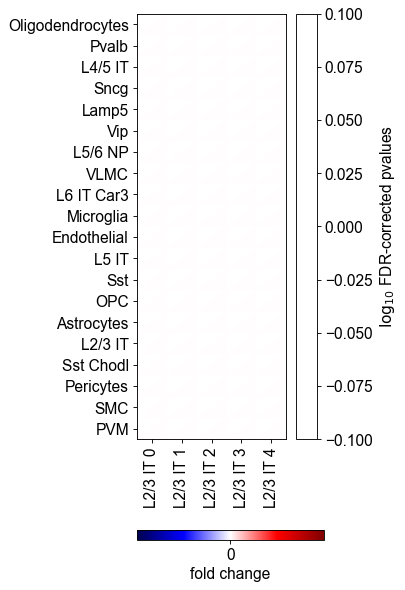

In [435]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    panel_width=3,
    pvalues_cmap=colors.ListedColormap(sns.color_palette("Greys", n_colors=300)[0]),
    linspace=(0.0, 0.0, 1)
)

# Chip Cytometry - colon

In [694]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='jarosch',
    data_path=datadir + 'jarosch/',
    radius=80,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


  0%|          | 0/2 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 2/2 [00:00<00:00, 11.15it/s]

Loaded 2 images with complete data from 1 patients over 11321 cells with 19 cell features and 12 distinct celltypes.
Mean of mean node degree per images across images: 18.522793

 Celldata metadata: {'lateral_resolution': 0.5, 'fn': 'raw_inflamed_colon_1.h5ad', 'image_col': 'Annotation', 'pos_cols': ['X', 'Y'], 'cluster_col': 'celltype_Level_2', 'cluster_col_preprocessed': 'celltype_Level_2_preprocessed', 'patient_col': None}


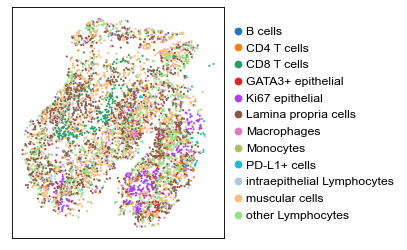

In [533]:
interpreter.data.spatial(
    image_key= "Area_1",
    fontsize=12,
    copy=False,
    panel_width=5,
    panel_height=5
)

n cells:  234
CD8 T cells 0    74
CD8 T cells 1    58
CD8 T cells 2    41
CD8 T cells 3    37
CD8 T cells 4    24
Name: CD8 T cells_substates, dtype: int64


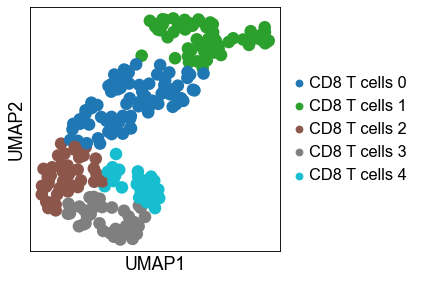

In [695]:
adata = interpreter.data.umap(
    image_key= "Area_1",
    target_cell_type='CD8 T cells',
    n_neighbors=22,
    n_pcs=None,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

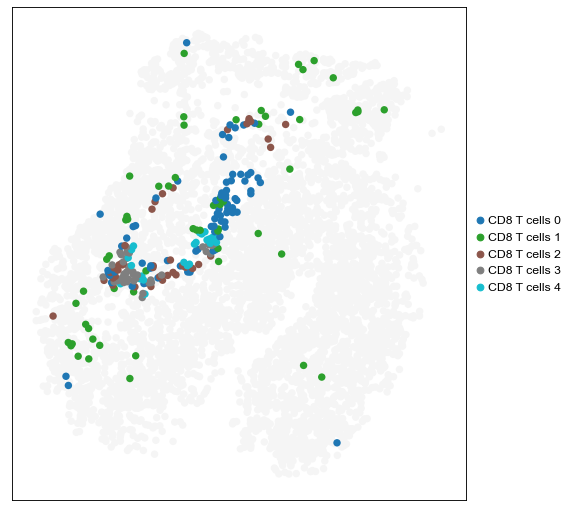

In [698]:
interpreter.data.spatial_substates(
    adata,
    image_key= "Area_1",
    target_cell_type='CD8 T cells',
    panel_width=7,
    panel_height=7,
    fontsize=12,
    spot_size=50
)

In [536]:
filter_titles = [
    'B cells',
    'CD4 T cells',
    'CD8 T cells',
    'GATA3+ epithelial',
    'Ki67 epithelial',
    'Lamina propria cells',
    'Macrophages',
    'Monocytes',
    'intraepithelial Lymphocytes',
    'muscular cells',
    'other Lymphocytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='Area_1',
    target_cell_type='CD8 T cells',
    clip_pvalues=-5,
    n_neighbors=22,
    n_pcs=None,
    filter_titles=filter_titles
)

100%|██████████| 16/16 [00:04<00:00,  3.97it/s]

n cells:  234
CD8 T cells 0    74
CD8 T cells 1    58
CD8 T cells 2    41
CD8 T cells 3    37
CD8 T cells 4    24
Name: CD8 T cells_substates, dtype: int64


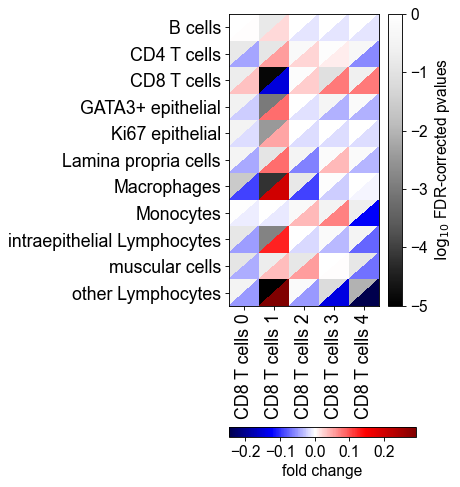

In [540]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    pad=0.25,
    panel_width=3,
    panel_height=8,
)

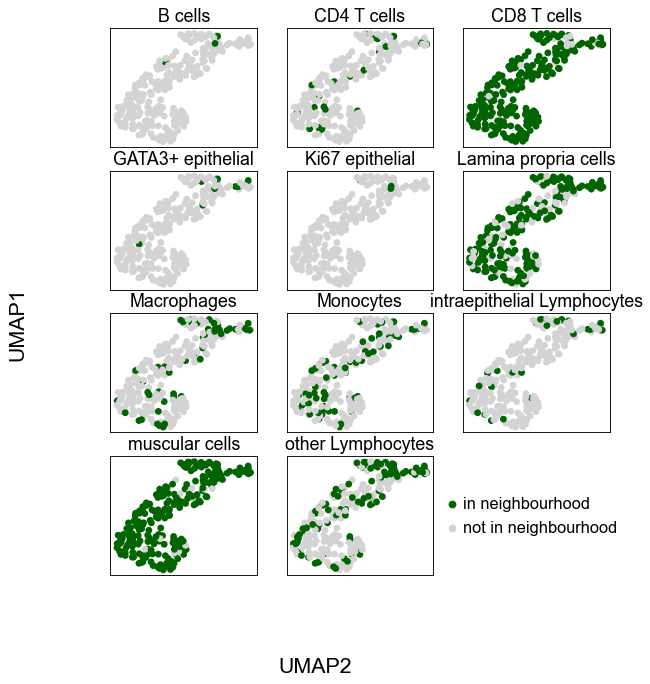

In [539]:
for i, x in enumerate(filter_titles):
    adata.uns[f"source type {x}_colors"] = ['darkgreen', 'lightgrey']
sc.set_figure_params(scanpy=True, fontsize=16)
plt.ioff()
fig, axs = plt.subplots(
    nrows=4, ncols=3, figsize=(8,9), )
fig.supxlabel("UMAP2")
fig.supylabel("UMAP1")
N = len(filter_titles)
#ax = trim_axs(ax, 25)
axs = axs.flat
for ax in axs[N:]:
    ax.remove()
ax = axs[:N]

for i, x in enumerate(filter_titles[:-1]):
    sc.pl.umap(
        adata,
        color=f"source type {x}",
        title=x,
        show=False,
        size=150,
        legend_loc='None',
        ax=ax[i]
    )
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
sc.pl.umap(
    adata,
    color=f"source type {filter_titles[-1]}",
    title=filter_titles[-1],
    show=False,
    size=150,
    ax=ax[N-1]
)
ax[N-1].set_xlabel('')
ax[N-1].set_ylabel('')
# Save, show and return figure.
#plt.tight_layout()
plt.show()

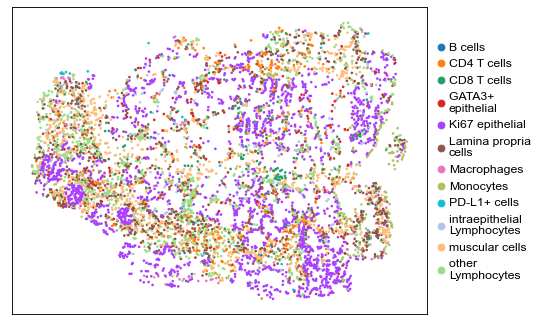

In [304]:
interpreter.data.spatial(
    image_key= "Area_2",
    fontsize=12,
    copy=False
)

n cells:  1076
muscular cells 0    293
muscular cells 1    250
muscular cells 2    249
muscular cells 3    160
muscular cells 4    124
Name: muscular cells_substates, dtype: int64


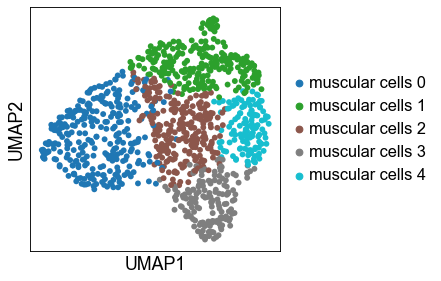

In [337]:
adata = interpreter.data.umap(
    image_key= "Area_2",
    target_cell_type='muscular cells',
    n_neighbors=80,
    n_pcs=None,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

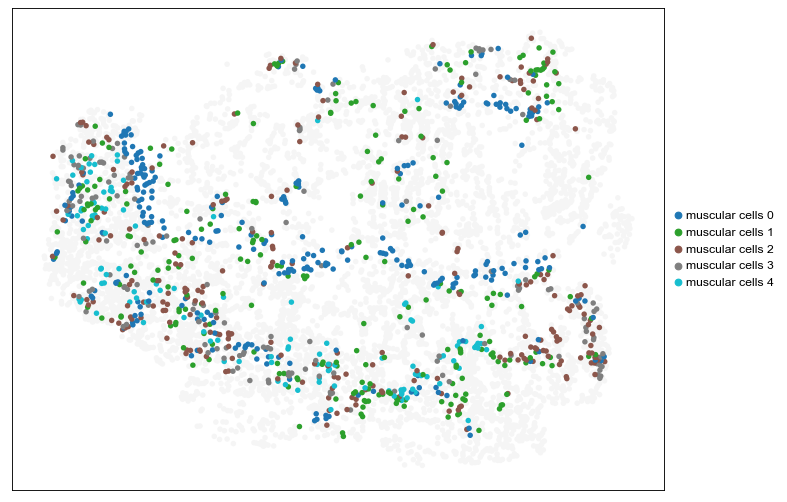

In [339]:
interpreter.data.spatial_substates(
    adata,
    image_key= "Area_2",
    target_cell_type='muscular cells',
    panel_width=10,
    panel_height=10,
    fontsize=12,
)

In [343]:
filter_titles = [
    #'B cells',
    'CD4 T cells',
    'CD8 T cells',
    'GATA3+ \nepithelial',
    'Ki67 epithelial',
    'Lamina propria \ncells',
    'Macrophages',
    'Monocytes',
    'intraepithelial \nLymphocytes',
    'muscular cells',
    'other \nLymphocytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='Area_2',
    target_cell_type='muscular cells',
    clip_pvalues=-5,
    n_neighbors=80,
    n_pcs=None,
    #filter_titles=filter_titles
)

100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

n cells:  1076
muscular cells 0    293
muscular cells 1    250
muscular cells 2    249
muscular cells 3    160
muscular cells 4    124
Name: muscular cells_substates, dtype: int64


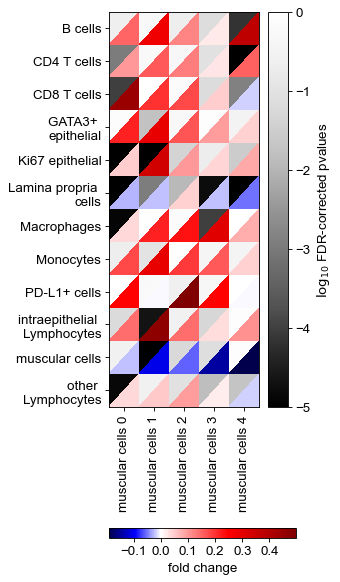

In [345]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=12,
    pad=0.2,
    panel_width=3,
    panel_height=10,
    #linspace=(-0.10, 0.7, 3)
)

In [61]:
interaction_matrix = []
for k, adata in interpreter.data.img_celldata.items():
    im = sq.gr.interaction_matrix(
        adata,
        cluster_key='celltype_Level_2_preprocessed',
        connectivity_key='adjacency_matrix',
        normalized=True,
        copy=True
    )
    interaction_matrix.append(im)
interaction_matrix = np.mean(np.array(interaction_matrix), axis=0)
interpreter.data.celldata.uns['celltype_Level_2_preprocessed_interactions'] = interaction_matrix

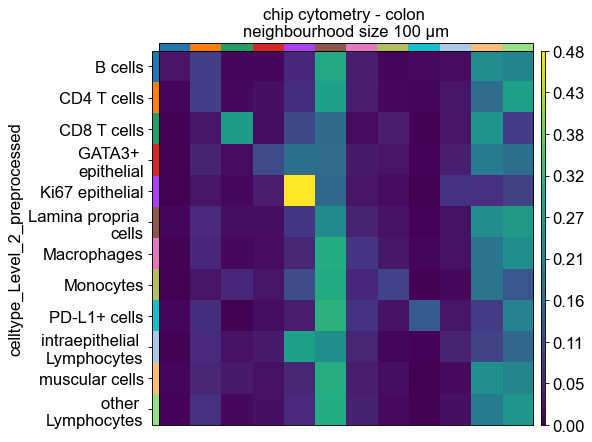

In [65]:
sc.set_figure_params(scanpy=True, fontsize=15)
sq.pl.interaction_matrix(
    interpreter.data.celldata,
    cluster_key='celltype_Level_2_preprocessed',
    connectivity_key='adjacency_matrix',
    figsize=(5,5),
    title='chip cytometry - colon \nneighbourhood size 100 μm'
)

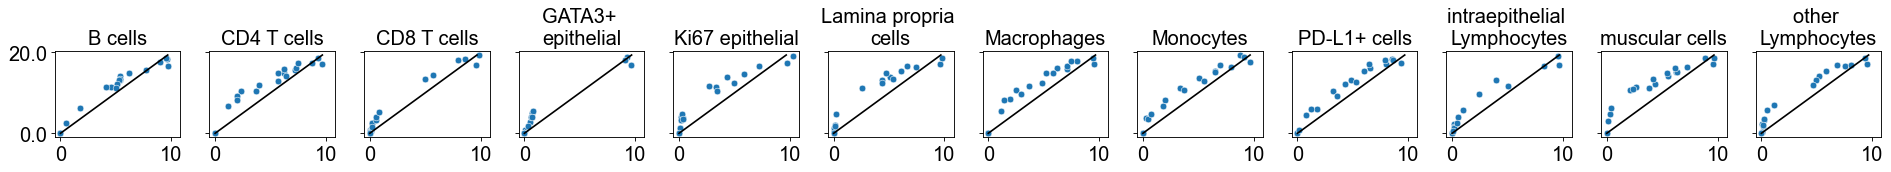

In [67]:
interpreter.data.noise_structure(panel_height=2.5)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 11321


  0%|          | 0/1000 [00:00<?, ?permutation/s]

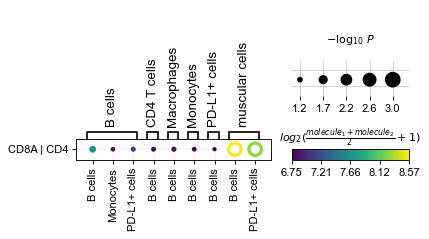

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [68]:
hgnc_names = [
    'CD14', 
    'MS4A1', 
    'IL2RA', 
    'CD3G', 
    'CD4', 
    'PTPRC',
    'PTPRC',
    'PTPRC',
    'CD68', 
    'CD8A', 
    'KRT5', # 'KRT1', 'KRT14'
    'FOXP3', 
    'GATA3', 
    'MKI67', 
    'Nuclei',
    'PDCD1', 
    'CD274', 
    'SMN1', 
    'VIM'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    seed=10,
    fontsize=12,
    width=2.
)

100%|██████████| 2/2 [00:06<00:00,  3.47s/it]


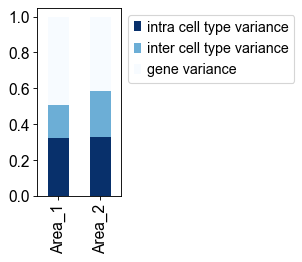

In [76]:
var_decomp = interpreter.data.compute_variance_decomposition()
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    multiindex=False
)

# MIBI TOF - cancer

In [677]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='hartmann',
    data_path=datadir + 'hartmann/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  0%|          | 0/58 [00:00<?, ?it/s]

collecting image-wise celldata
adding graph-level covariates


100%|██████████| 58/58 [00:00<00:00, 95.36it/s] 

Loaded 58 images with complete data from 4 patients over 63734 cells with 36 cell features and 8 distinct celltypes.
Mean of mean node degree per images across images: 4.416425

 Celldata metadata: {'lateral_resolution': 0.390625, 'fn': ['scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv', 'scMEP_sample_description.xlsx'], 'image_col': 'point', 'pos_cols': ['center_colcoord', 'center_rowcoord'], 'cluster_col': 'Cluster', 'cluster_col_preprocessed': 'Cluster_preprocessed', 'patient_col': 'donor'}


In [136]:
import pandas as pd
interaction_matrix = []
for k, adata in interpreter.data.img_celldata.items():
    im = sq.gr.interaction_matrix(
        adata,
        cluster_key='Cluster_preprocessed',
        connectivity_key='adjacency_matrix',
        normalized=True,
        copy=True
    )
    im = pd.DataFrame(im, columns=list(np.unique(adata.obs['Cluster_preprocessed'])), index=list(np.unique(adata.obs['Cluster_preprocessed'])))
    interaction_matrix.append(im)
df_concat = pd.concat(interaction_matrix)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean().sort_index(axis=1)
interpreter.data.celldata.uns['Cluster_preprocessed_interactions'] = np.array(df_means)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/networkx/linalg/attrmatrix.py:302: RuntimeWarning: invalid value encountered in true_divide
  M /= M.sum(axis=1).reshape((N, 1))


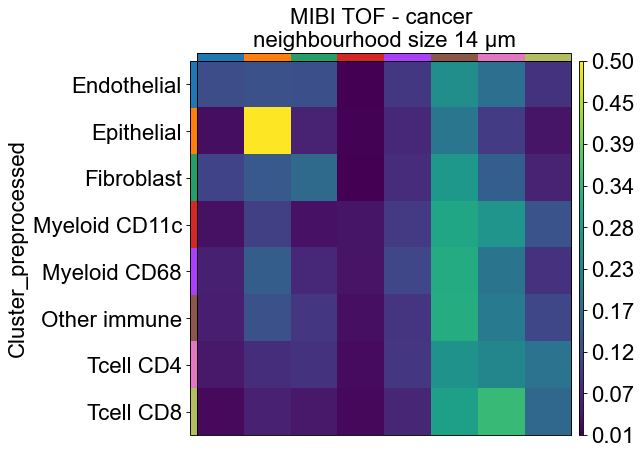

In [137]:
sc.set_figure_params(scanpy=True, fontsize=20)
sq.pl.interaction_matrix(
    interpreter.data.celldata,
    cluster_key='Cluster_preprocessed',
    connectivity_key='adjacency_matrix',
    figsize=(5,5),
    title='MIBI TOF - cancer \nneighbourhood size 14 μm'
)

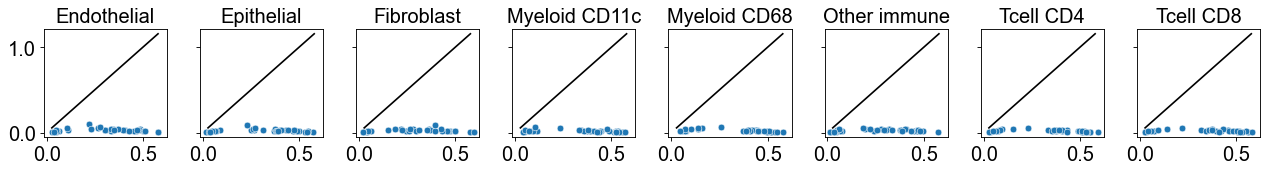

In [100]:
interpreter.data.noise_structure(panel_height=2.5)

n cells: 25493


  0%|          | 0/1000 [00:00<?, ?permutation/s]

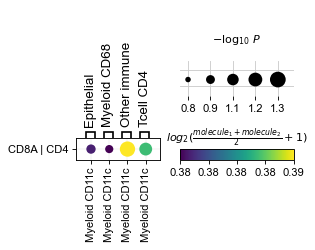

In [101]:
hgnc_names = [
    'H3-4', 
    'VIM', 
    'SMN1', 
    'SLC3A2', 
    'NFE2L2', 
    'CD4', 
    'CD14', 
    'PTPRC', 
    'PDCD1',
    'PECAM1', 
    'SDHA', 
    'MKI67', 
    'CS', 
    'RPS6', 
    'ITGAX', 
    'CD68', 
    'CD36', 
    'ATP5F1A',
    'CD247', 
    'ENTPD1', 
    'VDAC1', 
    'G6PD', 
    'XBP1', 
    'PKM', 
    'SLC1A5', 
    'SLC2A1', 
    'CD8A',
    'B3GAT1', 
    'LDHA', 
    'IDH2', 
    'HK1', 
    'CDH1', 
    'CPT1A', 
    'CKM', 
    'ATP1A1',
    'HIF1A'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    fraction=0.40,
    fontsize=12,
    width=2.,
)

100%|██████████| 58/58 [00:35<00:00,  1.63it/s]


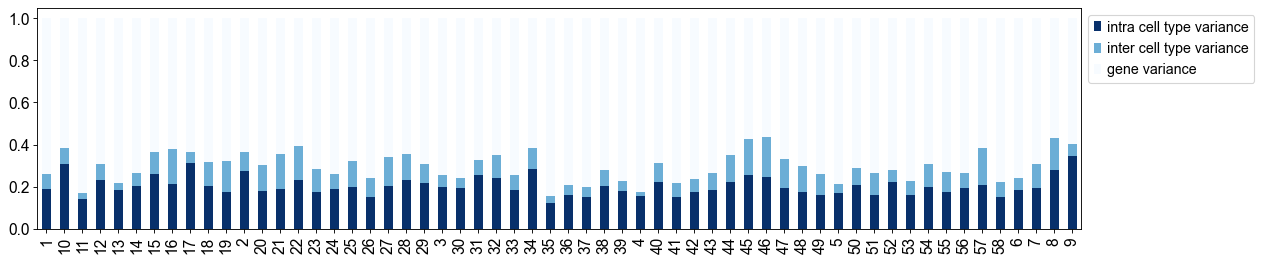

In [99]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    #panel_width=4,
    #multiindex=False
)

In [678]:
sc.pp.normalize_total(interpreter.data.img_celldata['16'])

... storing 'donor' as categorical
... storing 'Cluster' as categorical


n cells:  227
Tcell CD8 0    65
Tcell CD8 1    54
Tcell CD8 2    47
Tcell CD8 3    42
Tcell CD8 4    19
Name: Tcell CD8_substates, dtype: int64


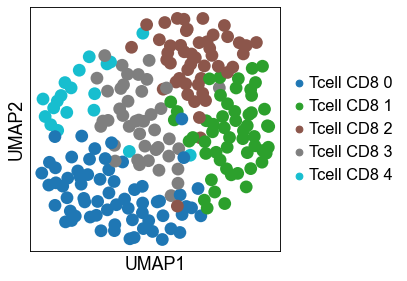

In [685]:
adata = interpreter.data.umap(
    image_key= "16",
    target_cell_type='Tcell CD8',
    n_neighbors=20,
    n_pcs=None,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical


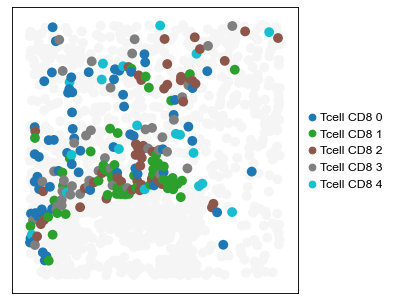

In [686]:
interpreter.data.spatial_substates(
    adata,
    image_key= "16",
    target_cell_type='Tcell CD8',
    panel_width=5,
    panel_height=5,
    fontsize=12,
)

In [687]:
adata = interpreter.data.img_celldata['16']
adata.obs['sf'] = interpreter.data.size_factors()['16']

In [626]:
adata

AnnData object with n_obs × n_vars = 1023 × 36
    obs: 'point', 'cell_id', 'donor', 'Cluster', 'Cluster_preprocessed', 'sf'
    uns: 'metadata', 'img_keys', 'img_to_patient_dict', 'node_type_names', 'graph_covariates', 'adjacency_matrix_neighbors'
    obsm: 'spatial', 'node_types'
    obsp: 'adjacency_matrix_connectivities', 'adjacency_matrix_distances'

Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Cluster' as categorical


[<AxesSubplot:title={'center':'Cluster_preprocessed'}, xlabel='spatial1', ylabel='spatial2'>]

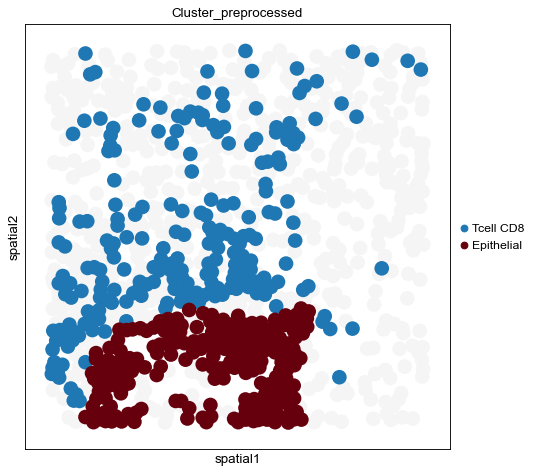

In [688]:
fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(7, 7), )
sc.pl.spatial(
    adata[adata.obs['Cluster_preprocessed'] != 'Tcell CD8'],
    spot_size=40,
    ax=ax,
    show=False,
    na_color='whitesmoke',
)
sc.pl.spatial(
    adata[adata.obs['Cluster_preprocessed'] == 'Tcell CD8'],
    color='Cluster_preprocessed',
    spot_size=40,
    ax=ax,
    show=False
)
sc.pl.spatial(
    adata[adata.obs['Cluster_preprocessed'] == 'Epithelial'],
    color='Cluster_preprocessed',
    palette='Reds_r',
    spot_size=40,
    ax=ax,
    show=False
)
#ax.invert_yaxis()

In [689]:
adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key='16',
    target_cell_type='Tcell CD8',
    clip_pvalues=-5,
    n_neighbors=20,
    n_pcs=None
)

100%|██████████| 124/124 [00:04<00:00, 24.98it/s]

n cells:  227
Tcell CD8 0    65
Tcell CD8 1    54
Tcell CD8 2    47
Tcell CD8 3    42
Tcell CD8 4    19
Name: Tcell CD8_substates, dtype: int64


In [690]:
filter_titles = list(np.unique(interpreter.data.celldata.obs['Cluster_preprocessed']))

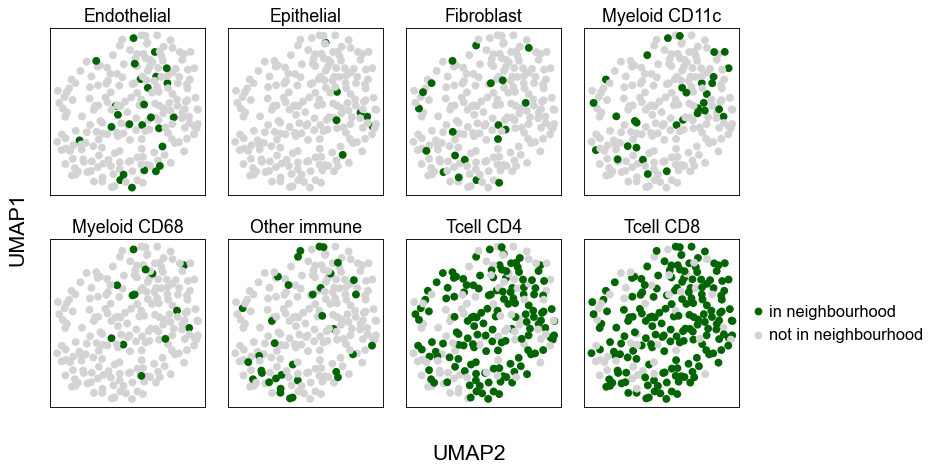

In [691]:
for i, x in enumerate(filter_titles):
    adata.uns[f"source type {x}_colors"] = ['darkgreen', 'lightgrey']
sc.set_figure_params(scanpy=True, fontsize=16)
plt.ioff()
fig, axs = plt.subplots(
    nrows=2, ncols=4, figsize=(4 * 3, 3 * 2), )
fig.supxlabel("UMAP2")
fig.supylabel("UMAP1")
N = len(filter_titles)
#ax = trim_axs(ax, 25)
axs = axs.flat
for ax in axs[N:]:
    ax.remove()
ax = axs[:N]

for i, x in enumerate(filter_titles[:-1]):
    sc.pl.umap(
        adata,
        color=f"source type {x}",
        title=x,
        show=False,
        size=200,
        legend_loc='None',
        ax=ax[i]
    )
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
sc.pl.umap(
    adata,
    color=f"source type {filter_titles[-1]}",
    title=filter_titles[-1],
    show=False,
    size=200,
    ax=ax[N-1]
)
ax[N-1].set_xlabel('')
ax[N-1].set_ylabel('')
# Save, show and return figure.
plt.tight_layout()
plt.show()


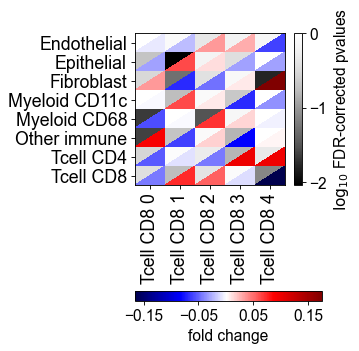

In [692]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    panel_width=3,
    panel_height=5,
    linspace=(-0.15, 0.15, 4),
    pad=0.35,
)

# MELC - tonsils data

In [115]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='pascualreguant',
    data_path=datadir + 'pascualreguant/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 1/1 [00:00<00:00, 11.68it/s]

collecting image-wise celldata
adding graph-level covariates
Loaded 1 images with complete data from 1 patients over 6991 cells with 51 cell features and 9 distinct celltypes.
Mean of mean node degree per images across images: 19.083107

 Celldata metadata: {'lateral_resolution': 0.325, 'fn': ['TONSIL_MFI_nuclei_data_table.xlsx', 'TONSIL_MFI_membranes_data_table.xlsx'], 'image_col': 'img_keys', 'pos_cols': ['Location_Center_X', 'Location_Center_Y'], 'cluster_col': 'cell_class', 'cluster_col_preprocessed': 'cell_class_preprocessed', 'patient_col': None}


In [116]:
sq.gr.interaction_matrix(
    interpreter.data.img_celldata['tonsil_image'],
    cluster_key='cell_class_preprocessed',
    connectivity_key='adjacency_matrix',
    normalized=True
)

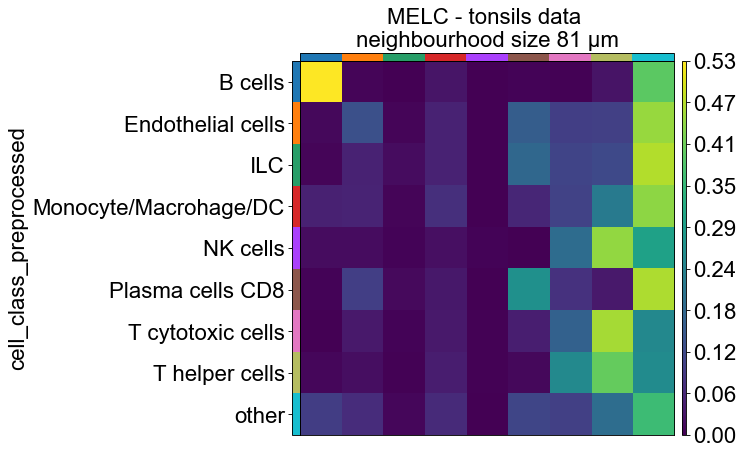

In [117]:
sc.set_figure_params(scanpy=True, fontsize=20)
sq.pl.interaction_matrix(
    interpreter.data.img_celldata['tonsil_image'],
    cluster_key='cell_class_preprocessed',
    connectivity_key='adjacency_matrix',
    figsize=(5,5),
    title='MELC - tonsils data \nneighbourhood size 81 μm'
)

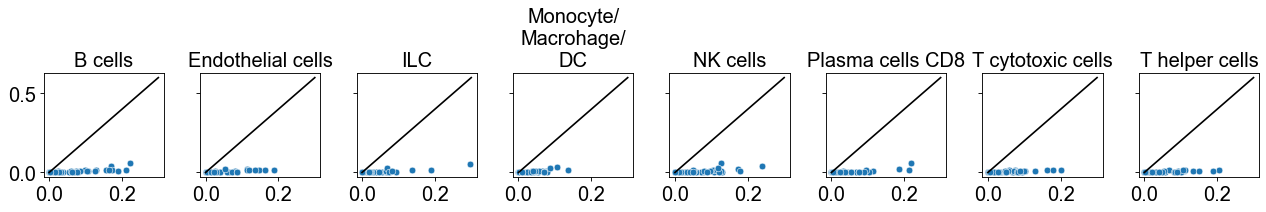

In [113]:
interpreter.data.noise_structure(
    undefined_type='other',
    min_x=0.0, max_x=0.3,
    panel_height=3
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 4470


  0%|          | 0/1000 [00:00<?, ?permutation/s]

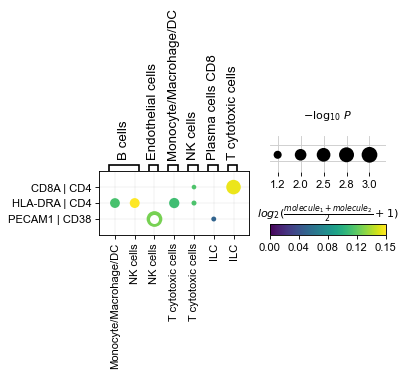

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [118]:
hgnc_names = [
    'BCL6', 
    'FOXP3', 
    'IKZF2', 
    'IRF4', 
    'MKI67', 
    'PAX5', 
    'CCR6', 
    'ITGAE',
    'ITGAX', 
    'IL3RA', 
    'IL7R', 
    'SDC1', 
    'CD14', 
    'THBD', 
    'FCGR3A', 
    'KLRB1',
    'CD19', 
    'MS4A1', 
    'CR2', 
    'FCER2', 
    'CD247', 
    'PECAM1', 
    'CD34', 
    'CD38', 
    'CD4',
    'PTPRC', 
    'PTPRC', 
    'PTPRC', 
    'ITGA1', 
    'NCAM1', 
    'CD69', 
    'CD7', 
    'CD8A',
    'KLRD1', 
    'CXCR3', 
    'FCER1A', 
    'GZMA', 
    'HLA-DRA', 
    'ICOS', 
    'CD79A', 
    'IGHG1',
    'IGHM', 
    'CD207', 
    'NCR2', 
    'TNFSF11', 
    'SMN1', 
    'TCRVa72', ## 
    'TRG', 
    'VCAM1',
    'VIM', 
    'KIT'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='other',
    fontsize=12,
    width=2.,
)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


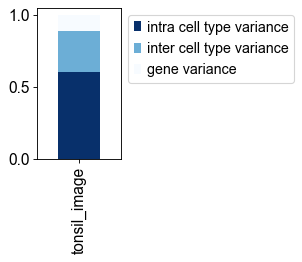

In [246]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=4,
    #multiindex=False
)

# CODEX - cancer

In [120]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_origin='schuerch',
    data_path=datadir + 'schuerch/',
    radius=60,
    node_label_space_id='type',
    node_feature_space_id='standard',
    merge_node_types_predefined=True
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata


  4%|▍         | 6/140 [00:00<00:02, 55.18it/s]

adding graph-level covariates


100%|██████████| 140/140 [00:02<00:00, 51.38it/s]


Loaded 140 images with complete data from 35 patients over 258385 cells with 57 cell features and 21 distinct celltypes.
Mean of mean node degree per images across images: 10.311835

 Celldata metadata: {'lateral_resolution': 0.377442, 'fn': 'CRC_clusters_neighborhoods_markers_NEW.csv', 'image_col': 'File Name', 'pos_cols': ['X:X', 'Y:Y'], 'cluster_col': 'ClusterName', 'cluster_col_preprocessed': 'ClusterName_preprocessed', 'patient_col': 'patients'}


In [122]:
import pandas as pd
interaction_matrix = []
for k, adata in interpreter.data.img_celldata.items():
    im = sq.gr.interaction_matrix(
        adata,
        cluster_key='ClusterName_preprocessed',
        connectivity_key='adjacency_matrix',
        normalized=True,
        copy=True
    )
    im = pd.DataFrame(im, columns=list(np.unique(adata.obs['ClusterName_preprocessed'])), 
                      index=list(np.unique(adata.obs['ClusterName_preprocessed'])))
    interaction_matrix.append(im)
df_concat = pd.concat(interaction_matrix)
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean().sort_index(axis=1)
interpreter.data.celldata.uns['ClusterName_preprocessed_interactions'] = np.array(df_means)

/Users/anna.schaar/opt/miniconda3/envs/ncem/lib/python3.8/site-packages/networkx/linalg/attrmatrix.py:302: RuntimeWarning: invalid value encountered in true_divide
  M /= M.sum(axis=1).reshape((N, 1))


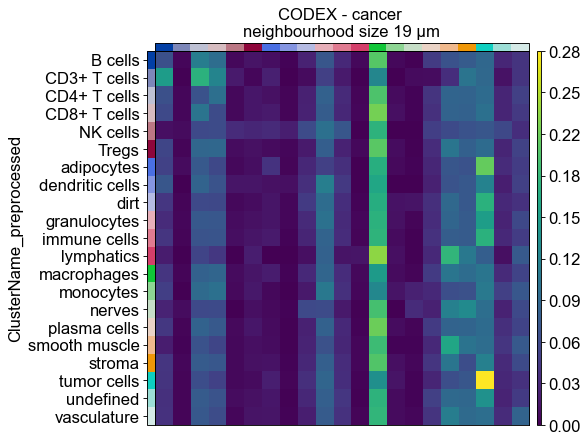

In [125]:
sc.set_figure_params(scanpy=True, fontsize=15)
sq.pl.interaction_matrix(
    interpreter.data.celldata,
    cluster_key='ClusterName_preprocessed',
    connectivity_key='adjacency_matrix',
    figsize=(5,5),
    title='CODEX - cancer \nneighbourhood size 19 μm'
)

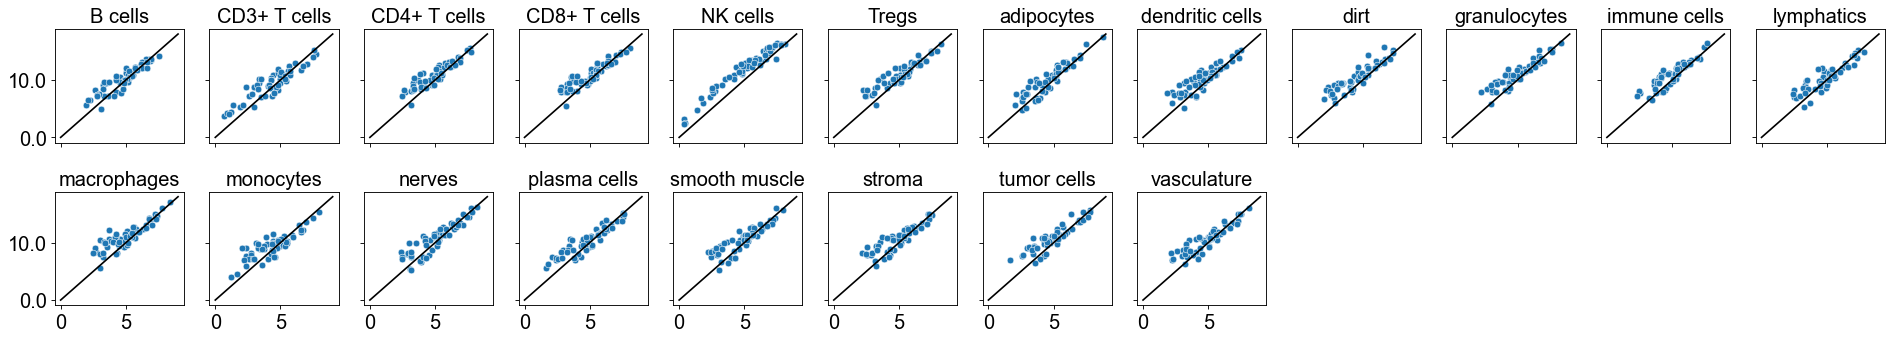

In [128]:
interpreter.data.noise_structure(
    undefined_type='undefined',
    min_x=0.0, max_x=9., panel_height=2.3
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


n cells: 25226


  0%|          | 0/1000 [00:00<?, ?permutation/s]

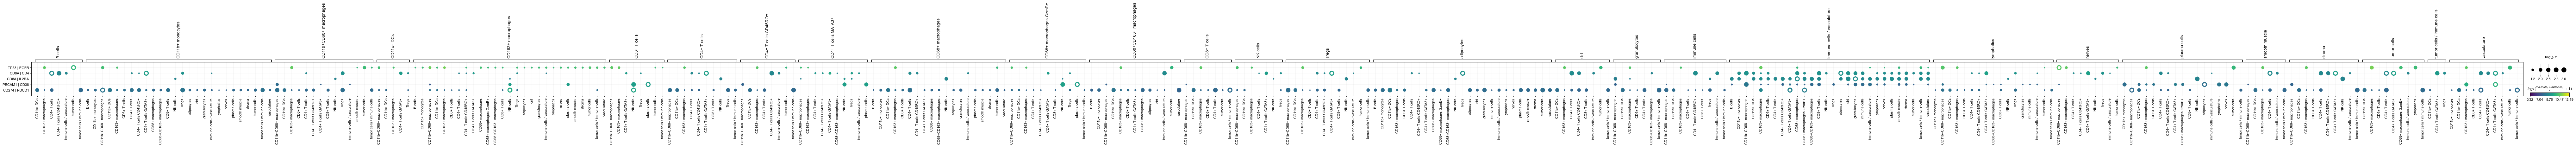

In [249]:
hgnc_names = [
    'CD44', 
    'FOXP3', 
    'CD8A', 'TP53', 
    'GATA3', 
    'PTPRC', 
    'TBX21', 
    'CTNNB1',
    'HLA-DR', 
    'CD274', 
    'MKI67', 
    'PTPRC', 
    'CD4', 
    'CR2', 
    'MUC1', 
    'TNFRSF8',
    'CD2', 
    'VIM', 
    'MS4A1', 
    'LAG3', 
    'ATP1A1', 
    'CD5', 
    'IDO1',
    'KRT1', 
    'ITGAM', 
    'NCAM1', 
    'ACTA1', 
    'BCL2', 
    'IL2RA', 
    'ITGAX',
    'PDCD1', 
    'GZMB', 
    'EGFR', 
    'VISTA', 
    'FUT4', 
    'ICOS', 
    'SYP',
    'GFAP', 
    'CD7', 
    'CD247', 
    'CHGA', 
    'CD163', 
    'PTPRC', 
    'CD68',
    'PECAM1', 
    'PDPN', 
    'CD34', 
    'CD38', 
    'SDC1', 
    'HOECHST1:Cyc_1_ch_1', ##
    'CDX2', 
    'COL6A1', 
    'CCR4', 
    'MMP9', 
    'TFRC', 
    'B3GAT1', 
    'MMP12'
]
adata = interpreter.data.ligrec(
    hgnc_names=hgnc_names,
    undefined_type='undefined',
    fraction=0.1,
    fontsize=12,
    width=2.,
)

100%|██████████| 140/140 [02:33<00:00,  1.09s/it]


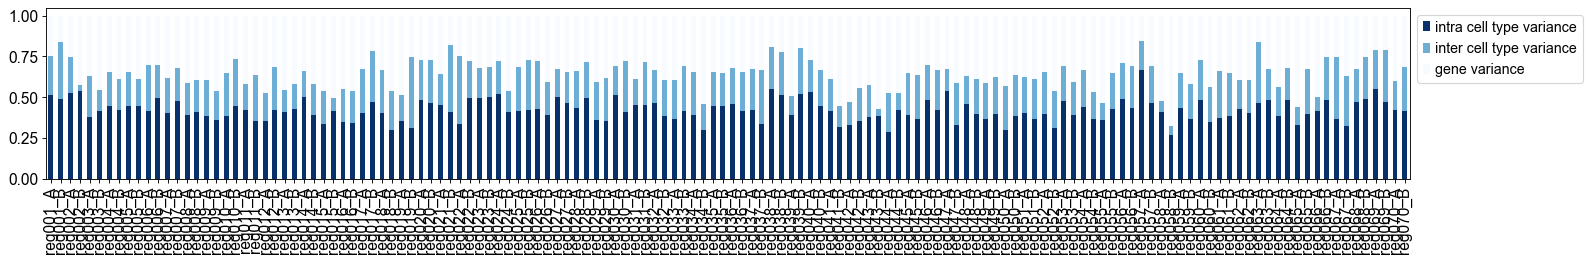

In [250]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='undefined')
interpreter.data.variance_decomposition(
    var_decomp, 
    panel_width=20,
    #multiindex=False
)